In [14]:
import numpy as np
import matplotlib.pyplot as plt
import os
from termcolor import colored

In [15]:
src_dir = os.path.dirname("ThrustVectorControl.ipynb")
docs_path = os.path.abspath(os.path.join(src_dir, '..', 'docs', 'data_TVC'))

if os.path.isdir(docs_path):
    print(f"{colored('Le fichier ', 'yellow')} {docs_path}, {colored('existe déja !', 'yellow')}")
else:
    os.makedirs(docs_path)

data_TVC_path = docs_path

In [16]:
class PID:
    def __init__(self, Kp, Ki, Kd):
        self.Kp = Kp
        self.Ki = Ki
        self.Kd = Kd
        self.integral = 0.0
        self.previous_error = 0.0

    def compute(self, error, dt):
        self.integral += error * dt
        derivative = (error - self.previous_error) / dt
        self.previous_error = error
        return self.Kp * error + self.Ki * self.integral + self.Kd * derivative

In [17]:
def rotation_matrix(theta, psi):

    # Angle de tangage
    c_theta = np.cos(theta)
    s_theta = np.sin(theta)

    R_theta = np.array([
        [c_theta, 0, s_theta],
        [0, 1, 0],
        [-s_theta, 0, c_theta]
    ])

    # Angle de lacet
    c_psi = np.cos(psi)
    s_psi = np.sin(psi)

    R_psi = np.array([
        [c_psi, -s_psi, 0],
        [s_psi, c_psi, 0],
        [0, 0, 1]
    ])

    return R_psi @ R_theta

In [18]:
# --> Paramètres
J_theta = 0.01
J_psi = 0.01
r = 0.5
Thrust = 50*1e3

# --> Gain des PIDs
Kp_theta, Ki_theta, Kd_theta = 10.0, 1.0, 2.0
Kp_psi, Ki_psi, Kd_psi = 10.0, 1.0, 2.0
PID_theta = PID(Kp=Kp_theta, Ki=Ki_theta, Kd=Kd_theta)
PID_psi = PID(Kp=Kp_psi, Ki=Ki_psi, Kd=Kd_psi)

# --> Paramètres de temps
dt = 0.001
simulation_time = 5.0
time_array = np.arange(0, simulation_time, dt)

# --> Paramètres désirés
theta_d = np.radians(-2.0)
psi_d = np.radians(2.0)

# --> Paramètres max
theta_max = np.radians(7.5)
psi_max = np.radians(7.5)

# --> Paramètres initiales
theta = np.radians(0)
theta_dot = np.radians(0)
psi = np.radians(0)
psi_dot = np.radians(0)

In [19]:
# Consignes variables
theta_ref_log = np.radians(5.0) * np.ones_like(time_array)
psi_ref_log = np.radians(2.0) * np.ones_like(time_array)

# Changement de consignes
theta_ref_log[time_array > 1.0] = np.radians(-5.0)
# theta_ref_log[time_array > 3.0] = np.radians(2.0)
theta_ref_log[time_array > 3.0] = np.radians(5.0)

# psi_ref_log[time_array > 2.0] = np.radians(-2.0)
# psi_ref_log[time_array > 4.0] = np.radians(1.0)
psi_ref_log[time_array > 2.0] = np.radians(-5.0)
psi_ref_log[time_array > 4.0] = np.radians(5.0)

# Initialisation des logs
theta_log = []
psi_log = []
theta_dot_log = []
psi_dot_log = []
error_theta_log = []
error_psi_log = []
tau_theta_log = []
tau_psi_log = []
energy_rot_log, energy_rot_theta_log, energy_rot_psi_log = [], [], []
Tx_log, Ty_log, Tz_log = [], [], []

# Initialisation des états
theta = 0.0
theta_dot = 0.0
psi = 0.0
psi_dot = 0.0

# Boucle de simulation
for idx, time in enumerate(time_array):
    
    # --> PID control
    theta_d = theta_ref_log[idx]
    psi_d = psi_ref_log[idx]
    
    error_theta = theta_d - theta
    error_psi = psi_d - psi
    force_theta = PID_theta.compute(error_theta, dt)
    force_psi = PID_psi.compute(error_psi, dt)

    # --> Moments
    tau_theta = r * force_theta
    tau_psi = r * force_psi

    # --> Dynamique
    def dynamics(state, tau_theta, tau_psi):
        _, theta_dot, _, psi_dot = state
        theta_ddot = tau_theta / J_theta
        psi_ddot = tau_psi / J_psi
        return np.array([theta_dot, theta_ddot, psi_dot, psi_ddot])
    
    # --> Intégration RK-4
    state = np.array([theta, theta_dot, psi, psi_dot])

    k1 = dynamics(state, tau_theta, tau_psi)
    k2 = dynamics(state + 0.5 * dt * k1, tau_theta, tau_psi)
    k3 = dynamics(state + 0.5 * dt * k2, tau_theta, tau_psi)
    k4 = dynamics(state + dt * k3, tau_theta, tau_psi)

    state += (dt / 6.0) * (k1 + 2*k2 + 2*k3 + k4)

    theta, theta_dot, psi, psi_dot = state

    # --> Limites des angles
    theta = np.clip(theta, -theta_max, theta_max)
    psi = np.clip(psi, -psi_max, psi_max)

    # --> Calcul du vecteur de poussée
    R = rotation_matrix(theta, psi)
    T0 = np.array([Thrust, 0, 0])
    T_vector = R @ T0

    # --> Énergie de rotation
    energy_rot_theta = 0.5 * J_theta * theta_dot**2
    energy_rot_psi = 0.5 * J_psi * psi_dot**2
    energy_rot = energy_rot_theta + energy_rot_psi

    # --> Logging
    theta_log.append(theta)
    psi_log.append(psi)
    theta_dot_log.append(theta_dot)
    psi_dot_log.append(psi_dot)
    error_theta_log.append(error_theta)
    error_psi_log.append(error_psi)
    tau_theta_log.append(tau_theta)
    tau_psi_log.append(tau_psi)

    energy_rot_theta_log.append(energy_rot_theta)
    energy_rot_psi_log.append(energy_rot_psi)
    energy_rot_log.append(energy_rot)
    
    Tx_log.append(T_vector[0])
    Ty_log.append(T_vector[1])
    Tz_log.append(T_vector[2])

In [20]:
theta_log = np.array(theta_log)
psi_log = np.array(psi_log)
theta_dot_log = np.array(theta_dot_log)
psi_dot_log = np.array(psi_dot_log)
theta_ref_log = np.array(theta_ref_log)
psi_ref_log = np.array(psi_ref_log)
error_theta_log = np.array(error_theta_log)
error_psi_log = np.array(error_psi_log)
tau_theta_log = np.array(tau_theta_log)
tau_psi_log = np.array(tau_psi_log)

energy_rot_theta_log = np.array(energy_rot_theta_log)
energy_rot_psi_log = np.array(energy_rot_psi_log)
energy_rot_log = np.array(energy_rot_log)

Tx_log = np.array(Tx_log)
Ty_log = np.array(Ty_log)
Tz_log = np.array(Tz_log)

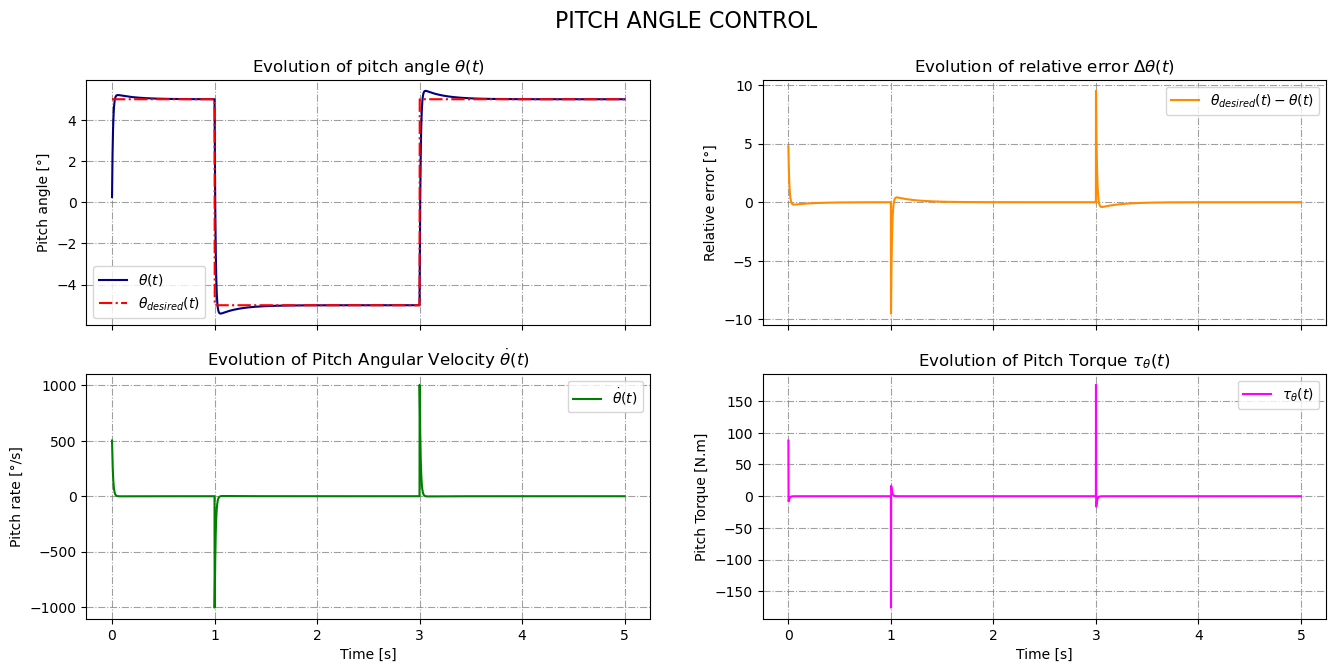

In [21]:
fig, axs = plt.subplots(2, 2, figsize=(16, 7), sharex=True)
fig.suptitle("PITCH ANGLE CONTROL", fontsize=16)

axs[0, 0].set_title(r"Evolution of pitch angle $\theta (t)$")
axs[0, 0].plot(time_array, np.rad2deg(theta_log), color='navy', label=r'$\theta (t)$')
axs[0, 0].plot(time_array, np.rad2deg(theta_ref_log), color='red', linestyle='-.', label=r'$\theta_{desired} (t)$')
axs[0, 0].set_ylabel('Pitch angle [°]')

axs[0, 1].set_title(r"Evolution of relative error $\Delta \theta (t)$")
axs[0, 1].plot(time_array, np.rad2deg(theta_ref_log - theta_log), color='darkorange', label=r"$\theta_{desired} (t) - \theta (t)$")
axs[0, 1].set_ylabel('Relative error [°]')

axs[1, 0].set_title(r"Evolution of Pitch Angular Velocity $\dot{\theta} (t)$")
axs[1, 0].plot(time_array, np.rad2deg(theta_dot_log), color='green', label=r"$\dot{\theta} (t)$")
axs[1, 0].set_xlabel('Time [s]')
axs[1, 0].set_ylabel('Pitch rate [°/s]')

axs[1, 1].set_title(r"Evolution of Pitch Torque $\tau_\theta (t)$")
axs[1, 1].plot(time_array, tau_theta_log, color='magenta', label=r"$\tau_\theta (t)$")
axs[1, 1].set_xlabel('Time [s]')
axs[1, 1].set_ylabel('Pitch Torque [N.m]')

for ax in axs.flat:
    ax.grid(True, linestyle='-.', alpha=0.75, color='gray')
    ax.legend()

pitch_name = 'pitch_control.png'
plt.savefig(os.path.join(data_TVC_path, pitch_name), dpi=300)

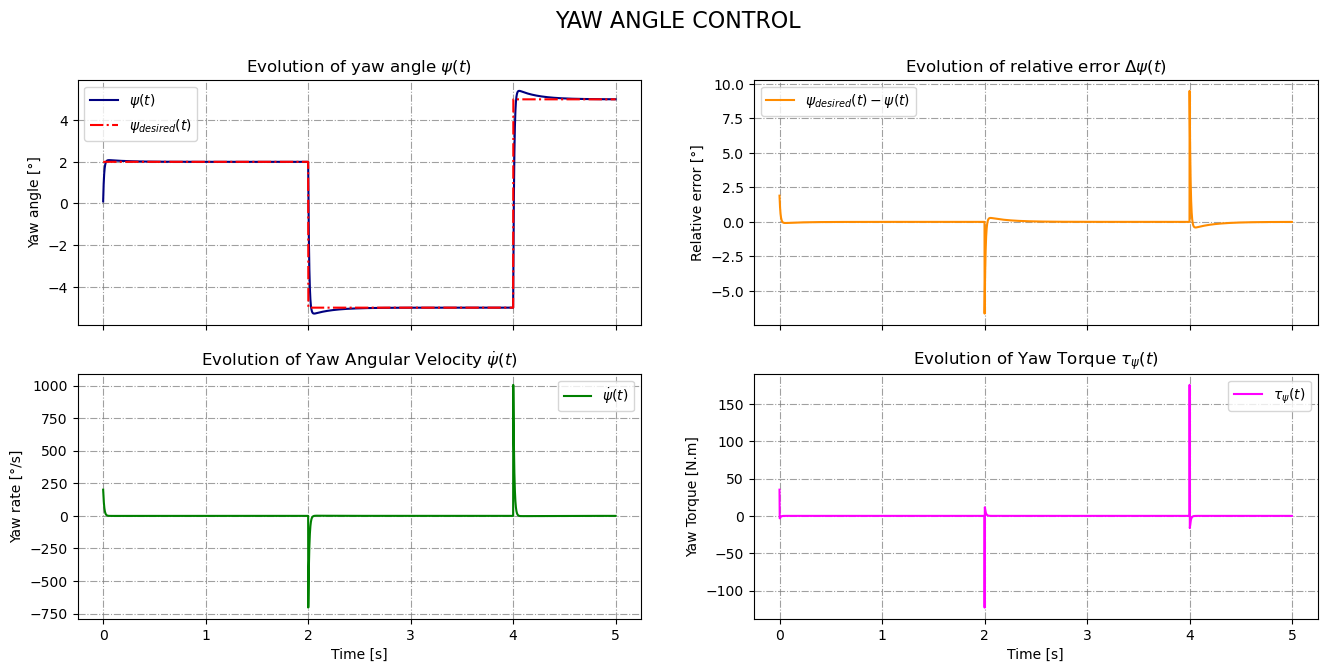

In [22]:
fig, axs = plt.subplots(2, 2, figsize=(16, 7), sharex=True)
fig.suptitle("YAW ANGLE CONTROL", fontsize=16)

axs[0, 0].set_title(r"Evolution of yaw angle $\psi (t)$")
axs[0, 0].plot(time_array, np.rad2deg(psi_log), color='navy', label=r'$\psi (t)$')
axs[0, 0].plot(time_array, np.rad2deg(psi_ref_log), color='red', linestyle='-.', label=r'$\psi_{desired} (t)$')
axs[0, 0].set_ylabel('Yaw angle [°]')

axs[0, 1].set_title(r"Evolution of relative error $\Delta \psi (t)$")
axs[0, 1].plot(time_array, np.rad2deg(psi_ref_log - psi_log), color='darkorange', label=r"$\psi_{desired} (t) - \psi (t)$")
axs[0, 1].set_ylabel('Relative error [°]')

axs[1, 0].set_title(r"Evolution of Yaw Angular Velocity $\dot{\psi} (t)$")
axs[1, 0].plot(time_array, np.rad2deg(psi_dot_log), color='green', label=r"$\dot{\psi} (t)$")
axs[1, 0].set_xlabel('Time [s]')
axs[1, 0].set_ylabel('Yaw rate [°/s]')

axs[1, 1].set_title(r"Evolution of Yaw Torque $\tau_\psi (t)$")
axs[1, 1].plot(time_array, tau_psi_log, color='magenta', label=r"$\tau_\psi (t)$")
axs[1, 1].set_xlabel('Time [s]')
axs[1, 1].set_ylabel('Yaw Torque [N.m]')

for ax in axs.flat:
    ax.grid(True, linestyle='-.', alpha=0.75, color='gray')
    ax.legend()

yaw_name = 'yaw_control.png'
plt.savefig(os.path.join(data_TVC_path, yaw_name), dpi=300)

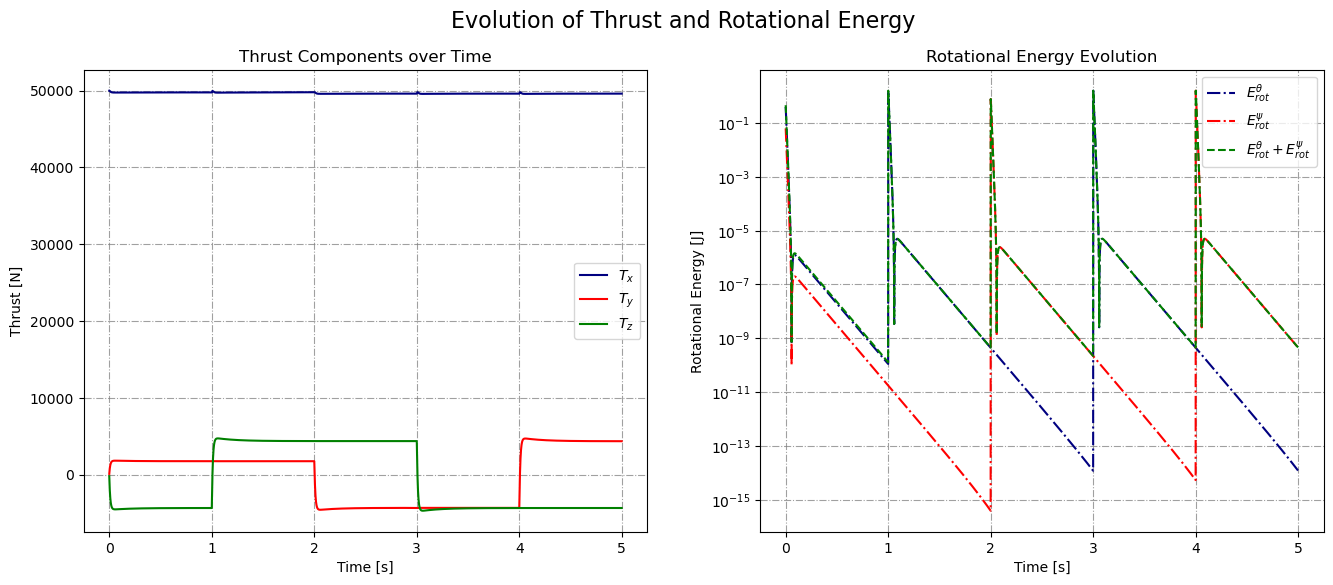

In [23]:
fig, axs = plt.subplots(1, 2, figsize=(16, 6))

axs[0].plot(time_array, Tx_log, color='navy', label=r"$T_x$")
axs[0].plot(time_array, Ty_log, color='red', label=r"$T_y$")
axs[0].plot(time_array, Tz_log, color='green', label=r"$T_z$")
axs[0].set_ylabel("Thrust [N]")
axs[0].set_xlabel('Time [s]')
axs[0].set_title("Thrust Components over Time")

axs[1].plot(time_array, energy_rot_theta_log, color='navy', linestyle='-.', label=r"$E_{rot}^{\theta}$")
axs[1].plot(time_array, energy_rot_psi_log, color='red', linestyle='-.', label=r"$E_{rot}^{\psi}$")
axs[1].plot(time_array, energy_rot_log, color='green', linestyle='--', label=r"$E_{rot}^{\theta} + E_{rot}^{\psi}$")
axs[1].set_ylabel("Rotational Energy [J]")
axs[1].set_xlabel('Time [s]')
axs[1].set_title("Rotational Energy Evolution")

for ax in axs.flat:
    ax.grid(True, linestyle='-.', alpha=0.75, color='gray')
    ax.legend(loc='best')
    ax.tick_params(axis='both', which='major')

axs[0].set_yscale('linear')

axs[1].set_yscale('log')


fig.suptitle("Evolution of Thrust and Rotational Energy", fontsize=16)

thrust_energy_name = 'thrust_energy.png'
plt.savefig(os.path.join(data_TVC_path, thrust_energy_name), dpi=300)

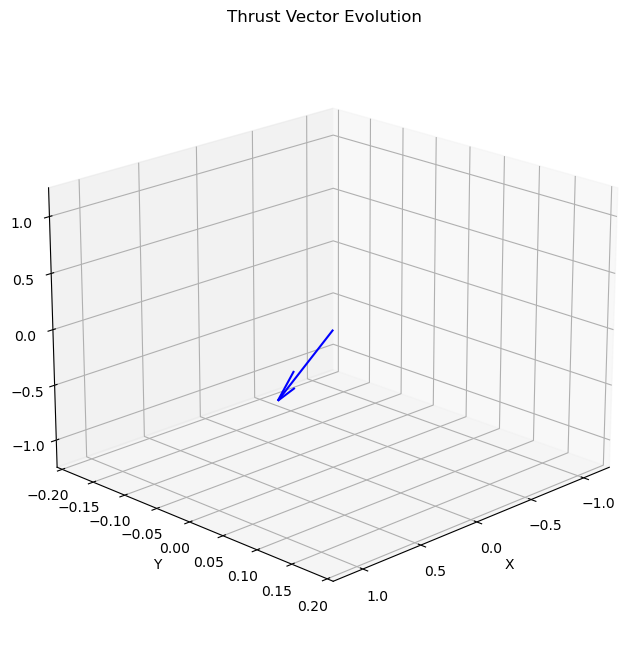

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation, PillowWriter
from mpl_toolkits.mplot3d import Axes3D

# -------------------------------
# Paramètre pour le nombre de frames
frame_step = 1  # Prendre 1 frame sur 2
# -------------------------------

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
ax.view_init(elev=20, azim=45)

# Définir les limites fixes
ax.set_xlim([-1.2, 1.2])
ax.set_ylim([-0.2, 0.2])
ax.set_zlim([-1.2, 1.2])

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title('Thrust Vector Evolution')

# Flèche initiale
quiver = ax.quiver(0, 0, 0, 0, 0, 0)

# Fonction d'update
def update_quiver(num):
    global quiver
    quiver.remove()  # Supprimer l'ancien vecteur

    idx = num * frame_step  # <-- Prendre 1 frame sur 2, 3, etc.

    if idx >= len(Tx_log):
        idx = len(Tx_log) - 1  # Sécurité pour ne pas dépasser

    T_vec = np.array([Tx_log[idx], Ty_log[idx], Tz_log[idx]])
    if np.linalg.norm(T_vec) != 0:
        T_vec_norm = T_vec / np.linalg.norm(T_vec)
    else:
        T_vec_norm = T_vec

    quiver = ax.quiver(0, 0, 0,
                       T_vec_norm[0], T_vec_norm[1], T_vec_norm[2],
                       length=1.0, normalize=True, color='blue')
    return quiver,

# --> Créer l'animation
n_frames = len(Tx_log) // frame_step  # <-- Moins de frames !
ani = FuncAnimation(fig, update_quiver, frames=n_frames, interval=50, blit=True)

# --> Sauvegarde en GIF
gif_path = os.path.join(data_TVC_path, 'thrust_vector.gif')
ani.save(gif_path, writer=PillowWriter(fps=20))

plt.show()